/var/folders/fl/fd_w98792vz_5scbbct57yfr0000gn/T/ipykernel_6222/4223001681.py:50: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  match_data['match_won'].fillna(0, inplace=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the docume

Logistic Regression Classification Report:
              precision    recall  f1-score   support

       False       0.97      1.00      0.98       195
        True       0.00      0.00      0.00         6

    accuracy                           0.97       201
   macro avg       0.49      0.50      0.49       201
weighted avg       0.94      0.97      0.96       201


Random Forest Classification Report:
              precision    recall  f1-score   support

       False       0.97      1.00      0.98       195
        True       0.00      0.00      0.00         6

    accuracy                           0.97       201
   macro avg       0.49      0.50      0.49       201
weighted avg       0.94      0.97      0.96       201



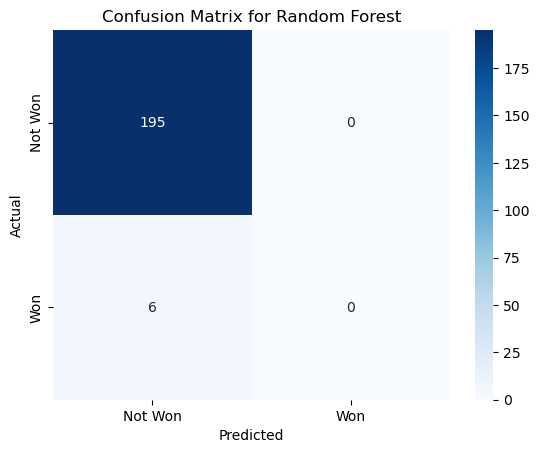

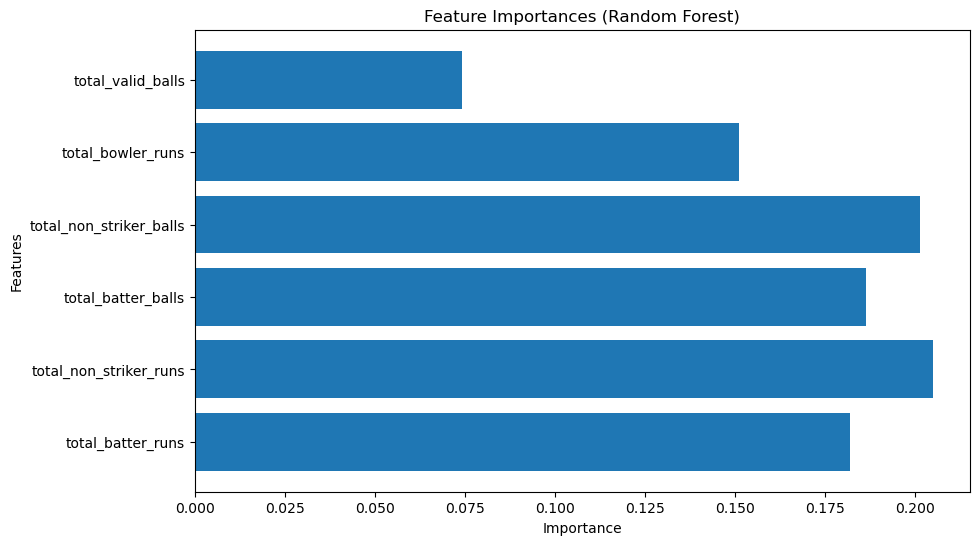

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load and preprocess data
file_path = 'ball_by_ball_ipl.csv'
df = pd.read_csv(file_path)

# Preprocessing: Selecting relevant columns
columns_to_keep = [
    'Match ID', 'Venue', 'Bat First', 'Bat Second', 'Winner',
    'Total Batter Runs', 'Total Non Striker Runs', 'Batter Balls Faced',
    'Non Striker Balls Faced', 'Bowler Runs Conceded', 'Valid Ball'
]
df = df[columns_to_keep]

# Convert categorical columns to numeric
categorical_columns = ['Venue', 'Bat First', 'Bat Second', 'Winner']
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

# Identify the target column for the winning team
winner_columns = [col for col in df.columns if col.startswith('Winner_')]
if not winner_columns:
    raise ValueError("No columns found for 'Winner_'. Check the dataset.")
target_column = winner_columns[0]  # Use the first 'Winner_' column as the target

# Aggregating match-level data
match_data = df.groupby('Match ID').agg(
    total_batter_runs=('Total Batter Runs', 'sum'),
    total_non_striker_runs=('Total Non Striker Runs', 'sum'),
    total_batter_balls=('Batter Balls Faced', 'sum'),
    total_non_striker_balls=('Non Striker Balls Faced', 'sum'),
    total_bowler_runs=('Bowler Runs Conceded', 'sum'),
    total_valid_balls=('Valid Ball', 'sum')
).reset_index()

# Adding match outcome (binary target variable)
match_data = match_data.merge(
    df[['Match ID', target_column]].drop_duplicates(),
    on='Match ID', how='left'
)
match_data.rename(columns={target_column: 'match_won'}, inplace=True)

# Fill missing target values with 0 (for matches not won by the encoded team)
match_data['match_won'].fillna(0, inplace=True)

# Splitting data into features and target
X = match_data.drop(columns=['Match ID', 'match_won'])
y = match_data['match_won']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
log_reg_preds = log_reg.predict(X_test)

# Random Forest Classifier
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)
rf_preds = rf_clf.predict(X_test)

# Evaluation
print("Logistic Regression Classification Report:")
print(classification_report(y_test, log_reg_preds))
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, rf_preds))

# Confusion Matrix for Random Forest
conf_matrix = confusion_matrix(y_test, rf_preds)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Won', 'Won'], yticklabels=['Not Won', 'Won'])
plt.title('Confusion Matrix for Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Feature Importance for Random Forest
feature_importances = rf_clf.feature_importances_
plt.figure(figsize=(10, 6))
plt.barh(X.columns, feature_importances)
plt.title('Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()
